## Take care of relative paths

In [1]:
# Here we take care of paths.
# Make sure root project directory is named 'VESUVIUS_Challenge' for this to work

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-18:] == 'VESUVIUS_Challenge':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in the root folder of the project
print('Current path:' + os.getcwd())

### Importing modules and packages

In [2]:
import torch
import monai
from monai.visualize import matshow3d
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from typing import Tuple, List
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from Data_Modules.Vesuvius_Dataset import Vesuvius_Tile_Datamodule
from lit_models.Vesuvius_Lit_Model import Lit_Model
from pytorch_lightning.callbacks import ModelCheckpoint




2023-05-15 14:43:16,266 - Created a temporary directory at /var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/tmpqpv6y3uw
2023-05-15 14:43:16,266 - Writing /var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/tmpqpv6y3uw/_remote_module_non_scriptable.py


### The following contains 'mps' as accelerator device for Apple M1 gpu


- ***Note: works with pytorch lightning version <2.0***


## Define config file, which will serve as hyperparameter sweep file

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

# change to the line below if not using Apple's M1 or chips
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
PATCH_SIZE = 256
Z_DIM = 16
COMPETITION_DATA_DIR_str =  "kaggle/input/vesuvius-challenge-ink-detection/"

class CFG:
    
    device = DEVICE
    
    THRESHOLD = 0.4
    use_wandb = False
    
    ######### Dataset #########
    
    # stage: 'train' or 'test'
    stage = 'train' 
    
    # location of competition Data
    competition_data_dir = COMPETITION_DATA_DIR_str
    
    # Number of slices in z-dim: 1<z_dim<65
    z_dim = Z_DIM
    
    # fragments to use for training avalaible [1,2,3]
    train_fragment_id=[2,3]
    
    # fragments to use for validation
    val_fragment_id=[1]
    
    

    
    
    batch_size = 16
    
    # Size of the patch and stride for feeding the model
    patch_size = PATCH_SIZE
    stride = patch_size // 2
    
    
    num_workers = 0
    on_gpu = True
    
    
    ######## Model and Lightning Model paramters ############
    
    # MODEL
    model = monai.networks.nets.FlexibleUNet(in_channels=z_dim,
                                         out_channels=1,
                                         backbone='efficientnet-b3',
                                         pretrained=True,
                                         decoder_channels=(512, 256, 128, 64, 32),
                                         spatial_dims=2,
                                         norm=('instance', {'eps': 0.001, 'momentum': 0.1}),
                                         # act=('relu', {'inplace': True}),
                                         act=None,
                                         dropout=0.0,
                                         decoder_bias=False,
                                         upsample='deconv',
                                         interp_mode='nearest',
                                         is_pad=False)
    
    
    
    
    
    checkpoint = None
    save_directory = None
    
    
    accumulate_grad_batches = 48 # experiments showed batch_size * accumulate_grad = 192 is optimal
    learning_rate = 0.0001
    eta_min = 5e-7
    t_max = 50
    max_epochs = 60
    weight_decay =  0.00001
    precision =16
    
    # checkpointing
    save_top_k=5
    
    monitor="FBETA"
    mode="max"
    
    
    ####### Augemtnations ###############
    
    # Training Aug
    train_transforms = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(patch_size, patch_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(patch_size * 0.3), max_height=int(patch_size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * z_dim,
            std= [1] * z_dim
        ),
        ToTensorV2(transpose_mask=True),
    ]
    

    
    # Validaiton Aug
    val_transforms = [
        A.Resize(patch_size, patch_size),
        A.Normalize(
            mean= [0] * z_dim,
            std= [1] * z_dim
        ),
        ToTensorV2(transpose_mask=True),
    ]
    
    # Test Aug
    test_transforms = [
        A.Resize(patch_size, patch_size),
        A.Normalize(
            mean=[0] * z_dim,
            std=[1] * z_dim
        ),

        ToTensorV2(transpose_mask=True),
    ]
        
    
    

### Initialize dataset

In [5]:
dataset = Vesuvius_Tile_Datamodule(cfg=CFG)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

### Looking under the hood (sanity check)

##### plots only  the first z_slice of the volumes

subvolume shape: torch.Size([16, 16, 256, 256])
inklabel shape: torch.Size([16, 1, 256, 256])
binary_mask torch.Size([16, 1, 256, 256])


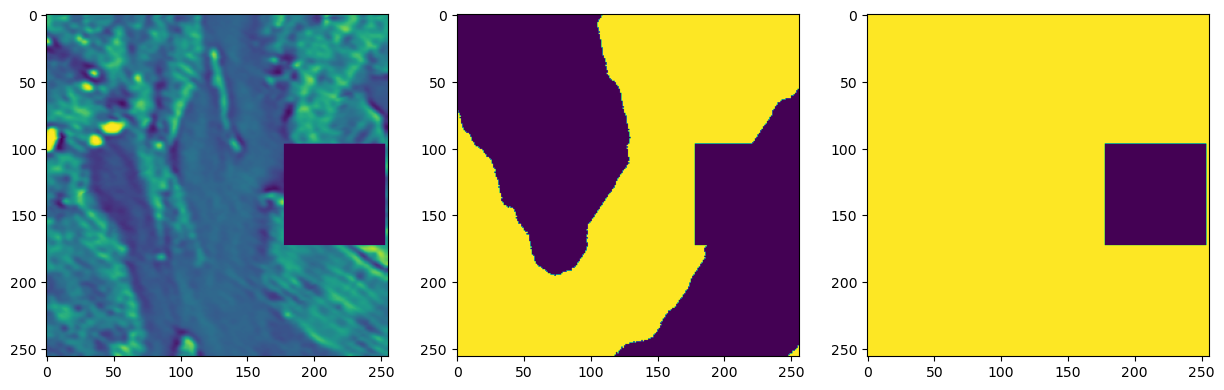

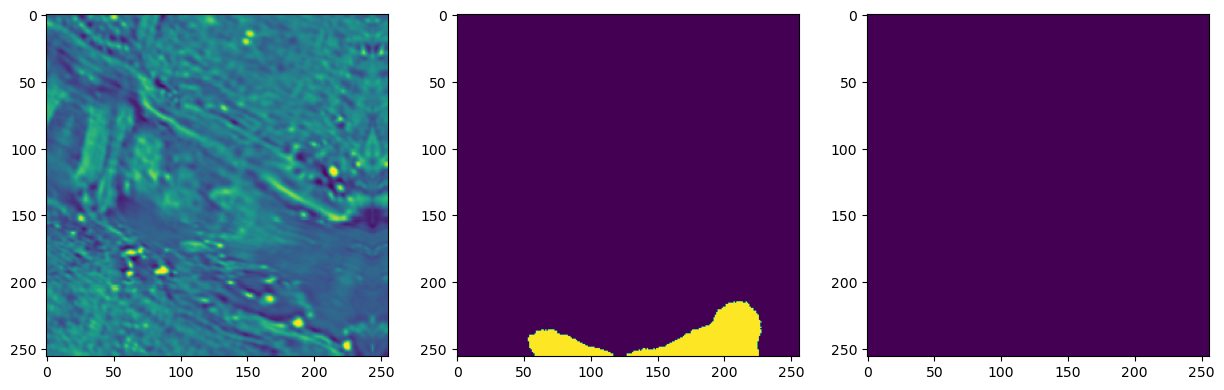

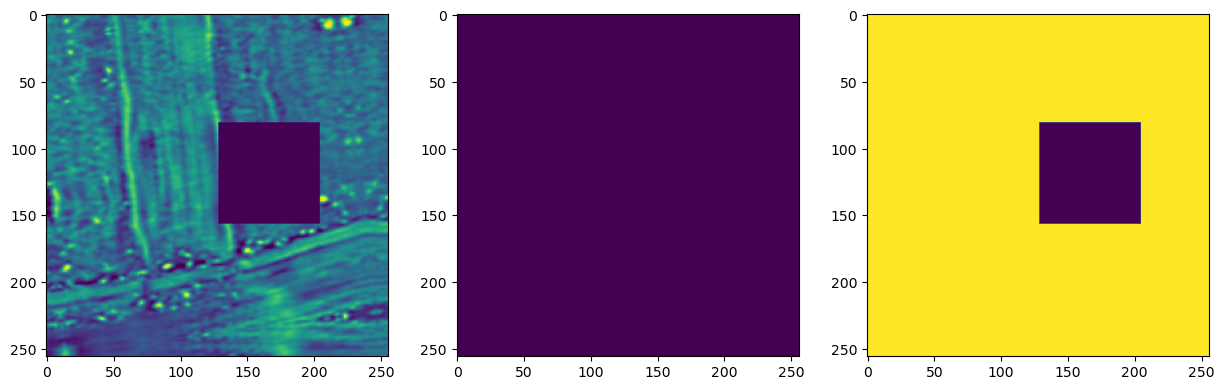

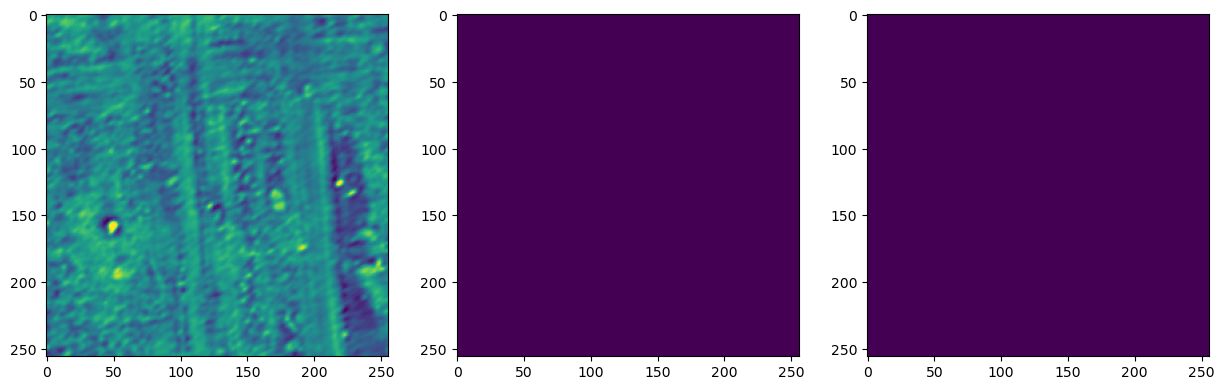

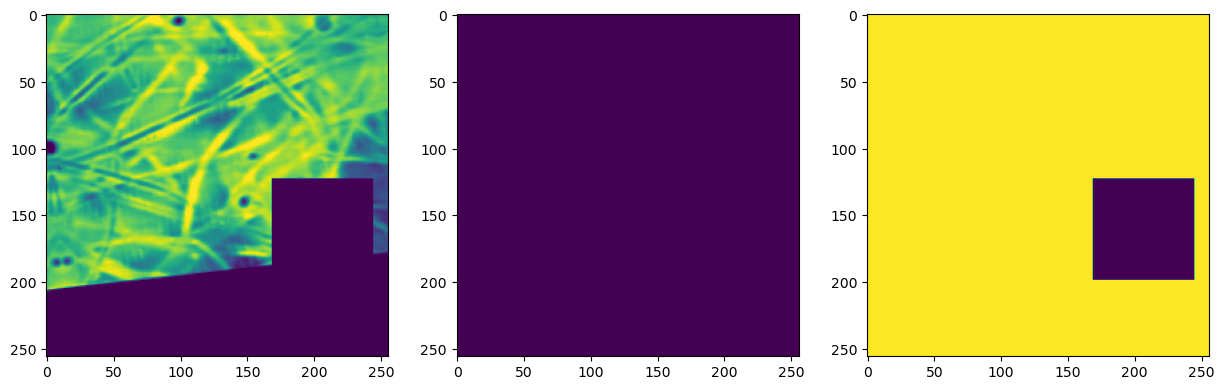

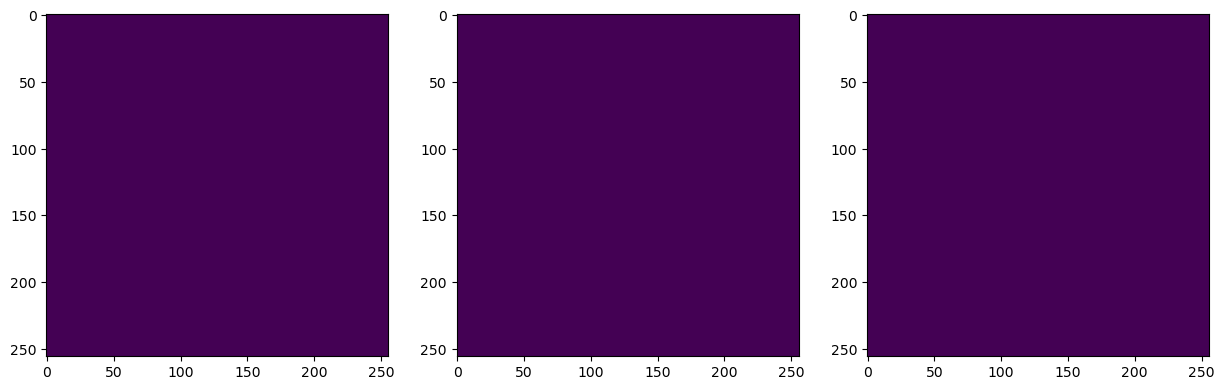

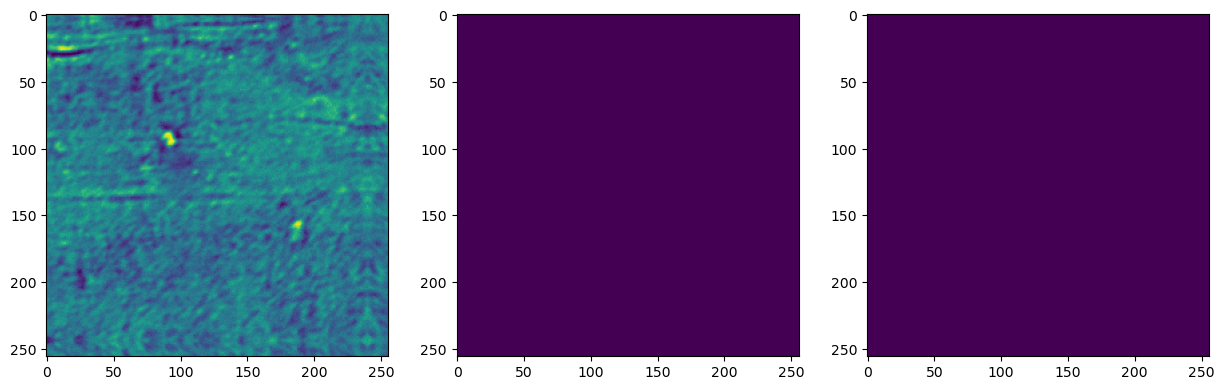

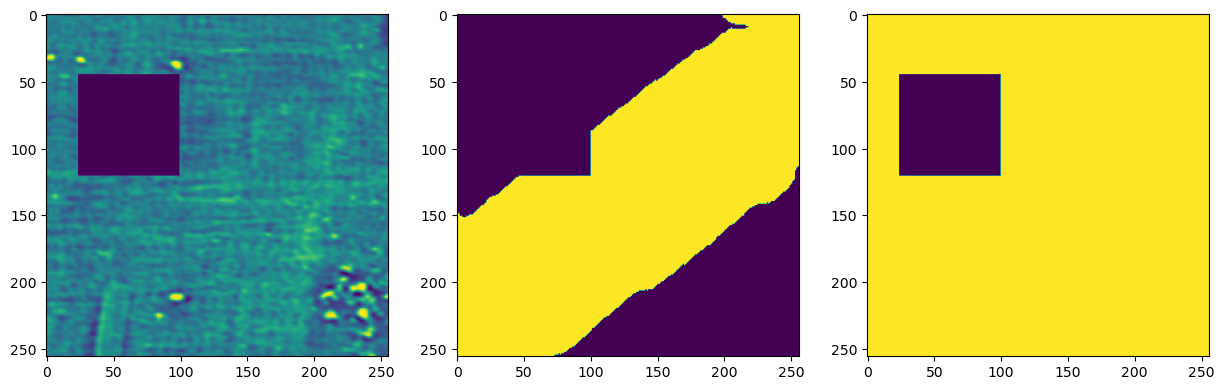

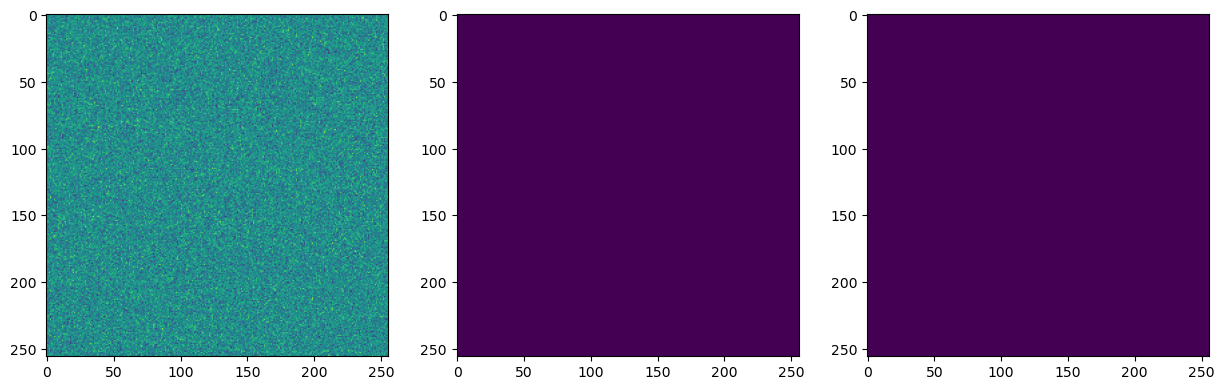

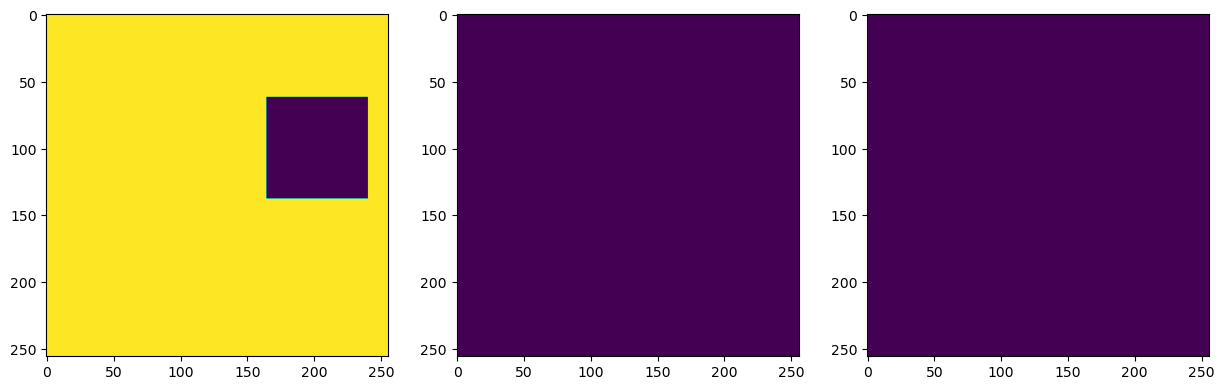

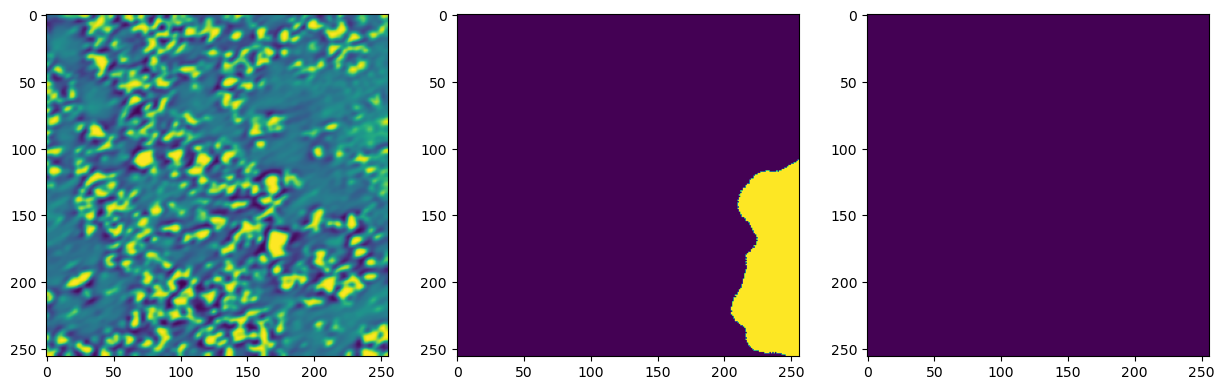

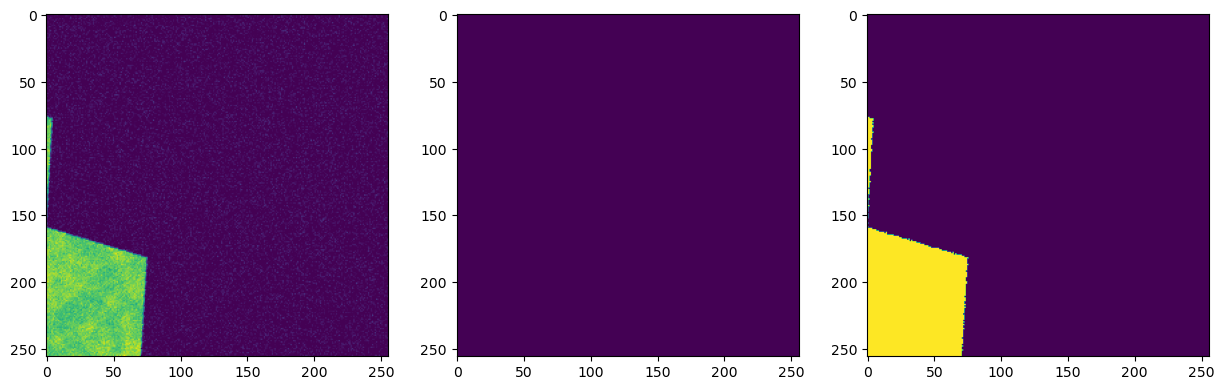

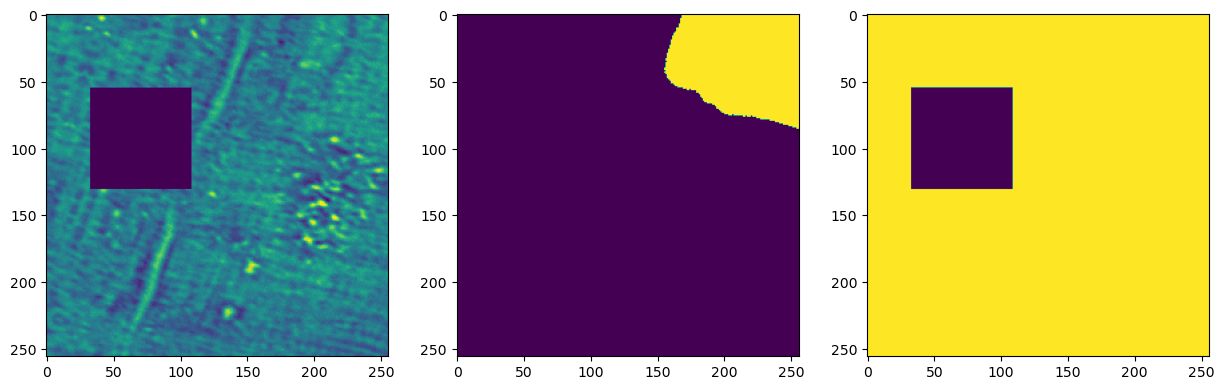

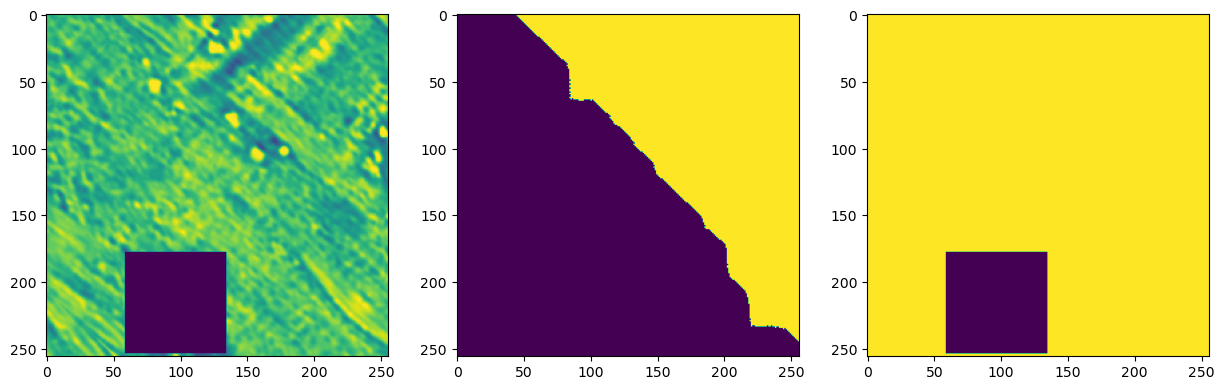

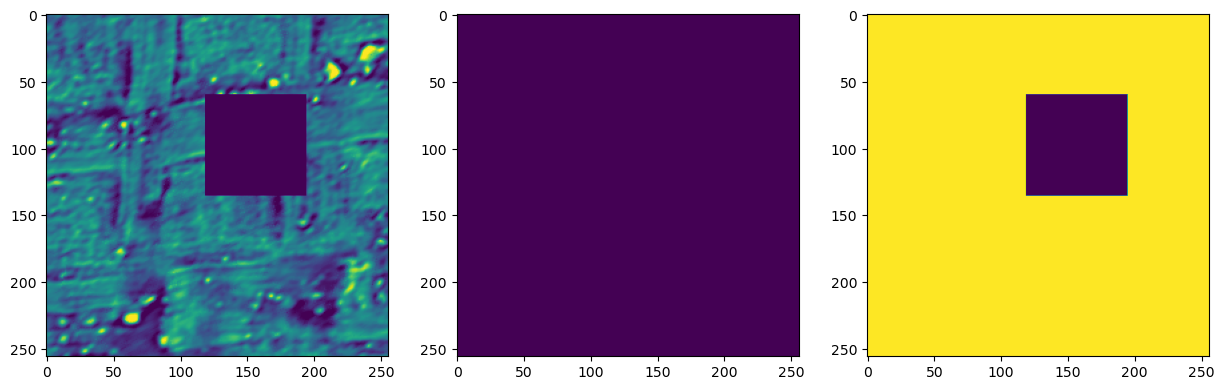

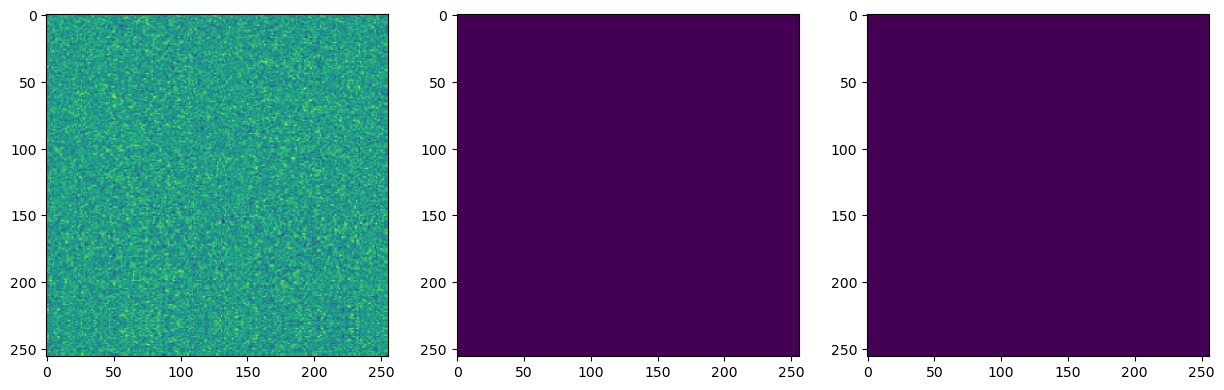

In [6]:
BATCHES_to_SHOW = 1

dataloader = iter(dataset.train_dataloader())
for i in range(BATCHES_to_SHOW):
    # Get image and label from train data -- change number for different ones
    subvolumes, inklabels, binary_masks = next(dataloader)
    print('subvolume shape:',subvolumes.shape)
    print('inklabel shape:',inklabels.shape)
    print('binary_mask', binary_masks.shape )
    
    for subvolume,  inklabel, binary_mask in zip(subvolumes, inklabels, binary_masks):
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                for idx, image in enumerate((subvolume,  inklabel, binary_mask)):
                    if idx==0:
                        axes[idx].imshow(image[0])
                    else:
                         axes[idx].imshow(image.squeeze(0))

                plt.show()
                
                


### 3D version check
- combines two slices together

In [7]:
# taken from https://www.kaggle.com/code/clemchris/vesuvis-pytorch-monai
def visualize_dataloaders(dataloaders, train=True):
    for stage, dataloader in dataloaders.items():
        for batch_idx, batch in enumerate(dataloader):
            volumes, labels = batch
           
            out = [volumes, labels]
            for volume,  label in zip(volumes,  labels):
                fig, axes = plt.subplots(1, 2, figsize=(10, 3))
                plt.suptitle(f"stage: {stage}, fragment: {batch_idx}")

                for idx, image in enumerate((volume, label)):
                    matshow3d(
                        volume=image,
                        fig=axes[idx],
                        title=f"{list(image.shape)}, {image.min().item()}, {image.max().item()}",
                        vmin=0.0,
                        vmax=1.0,
                        every_n=2,
                        fill_value=1.0,
                        margin=4,
                        cmap="gray",
                    )
            return out

In [8]:
dataloaders = {
    "train": dataset.train_dataloader(),
    "val": dataset.val_dataloader(),
}

batch = visualize_dataloaders(dataloaders)

ValueError: too many values to unpack (expected 2)

model =PyramidVisionTransformerV2(img_size=224,
                                  patch_size=4,
                                  in_chans=Z_DIM,
                                  num_classes=1,
                                  embed_dims=[64, 128, 256, 512],
                                num_heads=[1, 2, 4, 8],
                                  mlp_ratios=[8, 8, 4, 4],
                                  qkv_bias=True,
                                  qk_scale=None,
                                  drop_rate=0.,
                                attn_drop_rate=0.,
                                  drop_path_rate=0.,
                                  #norm_layer=nn.LayerNorm,
                                  depths=[3, 4, 18, 3],
                                  sr_ratios=[8, 4, 2, 1]
                                 )


In [11]:
from Models.PVT_model import PyramidVisionTransformerV2
import torch.nn as nn
from functools import partial

# WORKS WITH MAnet, PSPNet

class MyEncoder(torch.nn.Module, smp.encoders._base.EncoderMixin ):

    def __init__(self, **kwargs):
        super().__init__()
        
        self.model = PyramidVisionTransformerV2(img_size=224,
                                  patch_size=4,
                                  in_chans=Z_DIM,
                                  num_classes=1,
                                  embed_dims=[64, 128, 256, 512],
                                num_heads=[1, 2, 4, 8],
                                  mlp_ratios=[4, 4, 4, 4],
                                  qkv_bias=True,
                                  qk_scale=None,
                                  drop_rate=0.,
                                attn_drop_rate=0.,
                                  drop_path_rate=0.,
                                  norm_layer=partial(nn.LayerNorm, eps=1e-6),
                                  depths=[3, 4, 6, 3],
                                  sr_ratios=[8, 4, 2, 1]
                                 )


        # A number of channels for each encoder feature tensor, list of integers
        self._out_channels: List[int] = [64, 128, 256, 512]

        # A number of stages in decoder (in other words number of downsampling operations), integer
        # use in in forward pass to reduce number of returning features
        self._depth: int = 4

        # Default number of input channels in first Conv2d layer for encoder (usually 3)
        self._in_channels: int = 16

        # Define encoder modules below
        ...

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:
        """Produce list of features of different spatial resolutions, each feature is a 4D torch.tensor of
        shape NCHW (features should be sorted in descending order according to spatial resolution, starting
        with resolution same as input `x` tensor).

        Input: `x` with shape (1, 3, 64, 64)
        Output: [f0, f1, f2, f3, f4, f5] - features with corresponding shapes
                [(1, 3, 64, 64), (1, 64, 32, 32), (1, 128, 16, 16), (1, 256, 8, 8),
                (1, 512, 4, 4), (1, 1024, 2, 2)] (C - dim may differ)

        also should support number of features according to specified depth, e.g. if depth = 5,
        number of feature tensors = 6 (one with same resolution as input and 5 downsampled),
        depth = 3 -> number of feature tensors = 4 (one with same resolution as input and 3 downsampled).
        """
        
        
        out = self.model(x)

        return [x] + out
    
    
    


In [12]:
smp.encoders.encoders['PVT'] = {
    "encoder": MyEncoder, # encoder class here
    "pretrained_settings": {
        
    },
    "params": {
        # init params for encoder if any
    },
}

In [26]:
model = smp.PSPNet(encoder_name='PVT',
                   encoder_weights=None, 
                   encoder_depth=4, 
                   psp_out_channels=512,
                   psp_use_batchnorm=True,
                   psp_dropout=0.2,
                   in_channels=3, 
                   classes=1, 
                   activation=None,
                   upsampling=32,
                   aux_params=None)






In [27]:
print(subvolumes.shape)
out = model(subvolumes)

torch.Size([16, 16, 256, 256])


In [28]:
print(len(out), out.shape)


16 torch.Size([16, 1, 256, 256])


In [14]:
test_model =PyramidVisionTransformerV2(img_size=224,
                                  patch_size=4,
                                  in_chans=Z_DIM,
                                  num_classes=1,
                                  embed_dims=[64, 128, 256, 512],
                                num_heads=[1, 2, 4, 8],
                                  mlp_ratios=[4, 4, 4, 4],
                                  qkv_bias=True,
                                  qk_scale=None,
                                  drop_rate=0.,
                                attn_drop_rate=0.,
                                  drop_path_rate=0.,
                                  norm_layer=partial(nn.LayerNorm, eps=1e-6),
                                  depths=[3, 4, 6, 3],
                                  sr_ratios=[8, 4, 2, 1]
                                 )

In [15]:
test_out = test_model(subvolumes)

In [18]:
print(len(test_out))

for t in test_out:
    print(t.shape)

4
torch.Size([16, 64, 64, 64])
torch.Size([16, 128, 32, 32])
torch.Size([16, 256, 16, 16])
torch.Size([16, 512, 8, 8])


### Inititate Lit model

In [ ]:
lit_model = Lit_Model(cfg=CFG,)
    

### Training

In [ ]:
SAVE_DIR = 'logs/Test'

checkpoint_callback = ModelCheckpoint(
    save_top_k=5,
    monitor="FBETA",
    mode="max",
    dirpath=SAVE_DIR,
    filename="TEST_MODEL{epoch:02d}{FBETA:.2f}{val_loss:.2f}{fbeta_4:.2f}{recall:.2f}{precision:.2f}",
    save_last =True,
)


trainer = pl.Trainer(
        accelerator='mps',
        #benchmark=True,
        max_epochs=CFG.max_epochs,
        check_val_every_n_epoch= 1,
        devices=1,
        #fast_dev_run=fast_dev_run,
        logger=pl.loggers.CSVLogger(save_dir=SAVE_DIR),
        log_every_n_steps=1,
        default_root_dir = SAVE_DIR,
        #overfit_batches=1,
        precision=CFG.precision,
        accumulate_grad_batches=CFG.accumulate_grad_batches, 
        callbacks=[checkpoint_callback],
        #resume_from_checkpoint ='logs/MoUB3_Bce05+05Tver_instance/last.ckpt'
        
        )





trainer.fit(lit_model, datamodule=dataset,
            #ckpt_path='logs/Local_Originalgood/last.ckpt'
           )